# 1. Setup and get data

In [1]:
pip --version

pip 23.2.1 from c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip (python 3.11)

Note: you may need to restart the kernel to use updated packages.


## 1.1 Install dependencies

In [2]:
pip install tensorflow opencv-python matplotlib albumentations


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1.2 collect images using openCV

In [3]:
import os
import time
import uuid
import cv2

In [4]:
# Creating a path to store images
IMAGES_PATH = os.path.join('data', 'images')
number_images = 2
IMAGES_PATH

'data\\images'

In [5]:
cap = cv2.VideoCapture(0) # calling the function to capture images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum+1))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,'{}.jpg'.format(str(uuid.uuid1())))
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate images with LabelMe

In [6]:
#!labelme

# If this is not working, you can download the standalone app from:
# https://github.com/wkentaro/labelme/releases

# 2. Review dataset and build Image Loading function

## 2.1 Import TF and deps

In [7]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [8]:
print(tf.__version__)

2.13.0


## 2.2 Load images into TF data pipeline

In [9]:
images = tf.data.Dataset.list_files('/DoAn/face_detection/data/images/*.jpg', shuffle = False)

In [10]:
images.as_numpy_iterator().next()

b'\\DoAn\\face_detection\\data\\images\\2bbfd0b7-72fb-11ee-8871-1cbfc0415570.jpg'

In [11]:
images

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [12]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [13]:
images = images.map(load_image)

In [14]:
images.as_numpy_iterator().next()

array([[[110,  91,  74],
        [110,  91,  74],
        [111,  92,  75],
        ...,
        [166, 144, 130],
        [166, 144, 130],
        [167, 145, 131]],

       [[109,  90,  73],
        [109,  90,  73],
        [111,  92,  75],
        ...,
        [167, 145, 131],
        [166, 144, 130],
        [167, 145, 131]],

       [[108,  90,  70],
        [110,  92,  72],
        [112,  94,  74],
        ...,
        [166, 144, 130],
        [167, 145, 131],
        [168, 146, 132]],

       ...,

       [[ 55,  28,   9],
        [ 51,  23,   2],
        [ 58,  27,   6],
        ...,
        [201, 178, 162],
        [202, 179, 163],
        [203, 180, 164]],

       [[ 54,  27,   6],
        [ 52,  24,   3],
        [ 58,  27,   6],
        ...,
        [201, 175, 160],
        [200, 177, 161],
        [201, 178, 162]],

       [[ 54,  27,   6],
        [ 56,  30,   7],
        [ 61,  30,   9],
        ...,
        [200, 174, 159],
        [199, 176, 160],
        [200, 177, 161]]

In [15]:
images

<_MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>

In [16]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [17]:
len(images)

18

## 2.4 view raw images with matplotlib

In [18]:
image_generator = images.batch(4)
image_generator = image_generator.as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

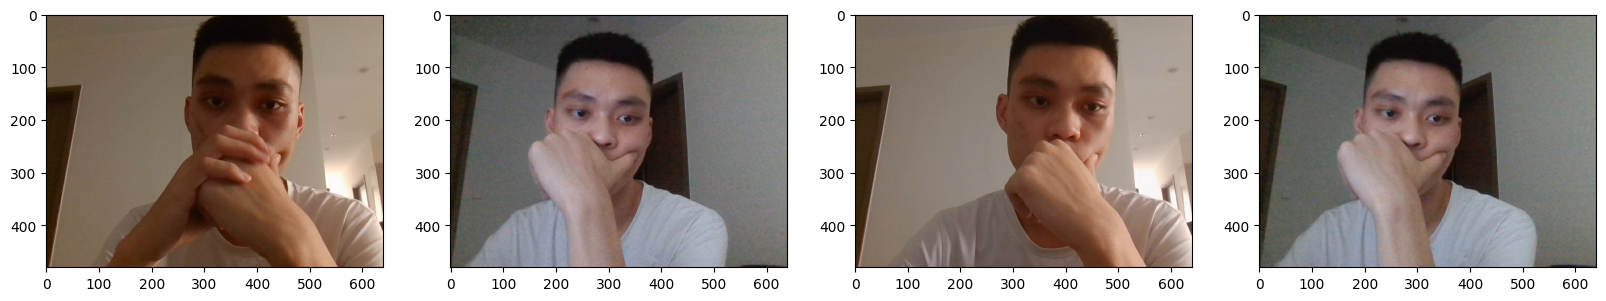

In [20]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for index, image in enumerate(plot_images):
    ax[index].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 Manually split data into train and test data

In [21]:
# 70% 63
# 15% 14 and 13

## 3.2 Move the matching labels

In [30]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image augumentation on images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipeline

In [23]:
#!pip install -U albumentations

In [24]:
import albumentations as alb

In [25]:
augumentor = alb.Compose([alb.RandomCrop(width = 600, height = 600),
                          alb.HorizontalFlip(p = 0.5),
                          alb.RandomBrightnessContrast(p = 0.2),
                          alb.RandomGamma(p = 0.2),
                          alb.RGBShift(p = 0.2),
                          alb.VerticalFlip(p = 0.5)],
                        bbox_params = alb. BboxParams(format = 'albumentations',
                                                      label_fields = ['class_labels']))

## 4.2 Load a test image and annotation with OpenCV and JSON

In [34]:
img = cv2.imread(os.path.join('data','train','images', '000001.jpg'))

In [35]:
img.shape

(218, 178, 3)

In [36]:
with open(os.path.join('data', 'train', 'labels', 'base64.json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

JSONDecodeError: Expecting value: line 4 column 13 (char 52)

## 4.3 Extract coordinates and rescale to match Image resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

NameError: name 'label' is not defined

In [ ]:
coords

[0, 0, 0, 0]

In [ ]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))
coords

[0.0, 0.0, 0.0, 0.0]

## 4.4 Apply augumentations and view results

In [ ]:
img.shape, coords

NameError: name 'coords' is not defined

In [ ]:
augumented = augumentor(image = img, bboxes = [coords], class_labels = ['face'])

NameError: name 'coords' is not defined

In [ ]:
augumented

NameError: name 'augumented' is not defined

In [ ]:
augumented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [ ]:
augumented['bboxes']

[(0.21031914893617018,
  0.015673758865248355,
  0.7776950354609927,
  0.5777304964539007)]

In [ ]:
first_two = augumented['bboxes'][0][:2]
last_two = augumented['bboxes'][0][2:]

first_two, last_two

((0.21031914893617018, 0.015673758865248355),
 (0.7776950354609927, 0.5777304964539007))

In [ ]:
cv2.rectangle(augumented['image'],
            tuple(np.multiply(first_two, [600,600]).astype(int)),
            tuple(np.multiply(last_two, [600,600]).astype(int)),
            (255,0,0), 2)
plt.imshow(augumented['image'])

NameError: name 'augumented' is not defined

# 5. Build and Run augumentation pipeline

In [ ]:
for partition in ['train', 'test', 'val']:
    for index, image in enumerate(os.listdir(os.path.join('data', partition, 'images'))):
        print(f"{partition} image: ------------------ {index+1}")
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [1280, 720, 1280, 720]))
        try:
            for x in range(5):
                augumented = augumentor(image = img, bboxes = [coords], class_labels = ['face'])
                print(f"saving aug image : {x+1}")
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augumented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augumented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augumented['bboxes'][0]
                        annotation['class'] = 1
                        
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['image'] = 0
                    
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
                    
        except Exception as e:
            print(e)

train image: ------------------ 1
Requested crop size (600, 600) is larger than the image size (480, 640)
train image: ------------------ 2


TypeError: list indices must be integers or slices, not str

for partition in ['train', 'test', 'val']:
    for label in (os.listdir(os.path.join('aug_data', partition, 'labels'))):
        label_path  = os.path.join('aug_data', partition, 'labels', label)
        print(label_path)
        with open(label_path, 'r') as f:
            label_json = json.load(f)
            if label_json != 0 and label_json != 1:
                print(os.path.join('aug_data', partition, 'labels', label))

## 5.2 Load Augumented images to Tensorflow Dataset

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: aug_data/train/images/*.jpg'

In [ ]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: aug_data/test/images/*.jpg'

In [ ]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: aug_data/val/images/*.jpg'

In [ ]:
train_images

NameError: name 'train_images' is not defined

In [ ]:
train_images.as_numpy_iterator().next()

NameError: name 'train_images' is not defined

In [ ]:
train_images.as_numpy_iterator().next().shape

(120, 120, 3)

# 6. Prepare Labels

# 6.1 Build label Loading function

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## 6.2 Load labels to Tensorflow dataset

In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels.as_numpy_iterator().next()

2023-05-01 18:02:32.865073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


(array([1], dtype=uint8),
 array([0.     , 0.079  , 0.10645, 0.744  ], dtype=float16))

# 7. Combine Label and Image Samples

## 7.1 Check Partition Lengths

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(30, 30, 10, 10, 10, 10)

## 7.2 Create final datasets

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(3000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(600)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(600)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train_labels.as_numpy_iterator().next()

2023-05-01 18:02:52.645760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [30]
	 [[{{node Placeholder/_0}}]]


(array([1], dtype=uint8),
 array([0.    , 0.0837, 0.2805, 0.743 ], dtype=float16))

In [ ]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.2234, 0.3486, 0.6846, 0.987 ],
        [0.    , 0.1818, 0.503 , 0.8003],
        [0.1683, 0.1448, 0.6294, 0.783 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.2695, 0.4917, 0.876 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.0837, 0.2805, 0.743 ],
        [0.    , 0.1467, 0.2245, 0.7656]], dtype=float16))

## 7.3 View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (0,255,255), 2)

    ax[idx].imshow(sample_image)

In [ ]:
res[1][0]

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

# 8. Build Deep Learning using the functional API

## 8.1 Import layers and Base Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [ ]:
vgg = VGG16(include_top = False)

58889256/58889256 [==============================] - 13s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build intance of Network

In [ ]:
def build_model():
    input_layer = Input(shape = (120,120,3))
    
    vgg = VGG16(include_top = False)(input_layer)
    
    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation = 'relu')(f1)
    class2 = Dense(1, activation = 'sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2)
    regress2 = Dense(2048, activation = 'sigmoid')(regress1)
    
    facetracker = Model(inputs = input_layer, outputs = [class2, regress2])
    return facetracker

## 8.4 Test our Neural Network

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_1 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                                

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [ ]:
classes, coords

(array([[0.53708357],
        [0.5769    ],
        [0.523813  ],
        [0.55950713],
        [0.5726559 ],
        [0.5450056 ],
        [0.49875623],
        [0.5239863 ]], dtype=float32),
 array([[0.45165455, 0.5461338 , 0.45679948, ..., 0.44770357, 0.4680375 ,
         0.5612289 ],
        [0.5099758 , 0.49974808, 0.47336516, ..., 0.45161927, 0.4493663 ,
         0.52205473],
        [0.43425414, 0.5239114 , 0.4997101 , ..., 0.43501085, 0.4376911 ,
         0.56547034],
        ...,
        [0.44703957, 0.48126972, 0.4713387 , ..., 0.45652258, 0.40687037,
         0.5673002 ],
        [0.4926426 , 0.47026348, 0.46226457, ..., 0.44348475, 0.40796036,
         0.53922254],
        [0.5358311 , 0.4651953 , 0.45955077, ..., 0.46416882, 0.44395545,
         0.55703163]], dtype=float32))

# 9. define Lossess and Optimizers

## 9.1 Define optimizers and LR

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1) / batches_per_epoch
lr_decay

0.08333333333333331

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test our Metrics

In [ ]:
y[1][:]

array([[0.     , 0.2778 , 0.3176 , 0.8843 ],
       [0.1027 , 0.2401 , 0.597  , 0.9    ],
       [0.6323 , 0.1812 , 1.     , 0.8    ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.722  , 0.04947, 1.     , 0.6685 ],
       [0.824  , 0.3103 , 1.     , 0.9487 ],
       [0.     , 0.     , 0.     , 0.     ]], dtype=float16)

In [ ]:
coords

array([[0.45165455, 0.5461338 , 0.45679948, ..., 0.44770357, 0.4680375 ,
        0.5612289 ],
       [0.5099758 , 0.49974808, 0.47336516, ..., 0.45161927, 0.4493663 ,
        0.52205473],
       [0.43425414, 0.5239114 , 0.4997101 , ..., 0.43501085, 0.4376911 ,
        0.56547034],
       ...,
       [0.44703957, 0.48126972, 0.4713387 , ..., 0.45652258, 0.40687037,
        0.5673002 ],
       [0.4926426 , 0.47026348, 0.46226457, ..., 0.44348475, 0.40796036,
        0.53922254],
       [0.5358311 , 0.4651953 , 0.45955077, ..., 0.46416882, 0.44395545,
        0.55703163]], dtype=float32)

In [ ]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.3977056>

In [ ]:
y[0]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0]], dtype=uint8)

In [ ]:
classes

array([[0.53708357],
       [0.5769    ],
       [0.523813  ],
       [0.55950713],
       [0.5726559 ],
       [0.5450056 ],
       [0.49875623],
       [0.5239863 ]], dtype=float32)

In [ ]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6916549>

In [ ]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.3977056>

# 10. Train Neural Network

## 10.1 Create Custom Model Class

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(train, epochs = 10, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/10
4/4 [==============================] - ETA: 0s - total_loss: 3.1951 - class_loss: 0.6350 - regress_loss: 2.8776

2023-05-01 19:05:48.945091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10]
	 [[{{node Placeholder/_5}}]]
2023-05-01 19:05:48.945741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10]
	 [[{{node Placeholder/_5}}]]


4/4 [==============================] - 17s 4s/step - total_loss: 2.7953 - class_loss: 0.5865 - regress_loss: 2.5020 - val_total_loss: 0.4183 - val_class_loss: 0.2428 - val_regress_loss: 0.2969
Epoch 2/10
4/4 [==============================] - 13s 3s/step - total_loss: 1.5267 - class_loss: 0.5059 - regress_loss: 1.2737 - val_total_loss: 0.7006 - val_class_loss: 0.1387 - val_regress_loss: 0.6312
Epoch 3/10
4/4 [==============================] - 13s 3s/step - total_loss: 1.2566 - class_loss: 0.4699 - regress_loss: 1.0216 - val_total_loss: 0.6971 - val_class_loss: 0.1892 - val_regress_loss: 0.6024
Epoch 4/10
4/4 [==============================] - 12s 3s/step - total_loss: 1.1115 - class_loss: 0.3496 - regress_loss: 0.9367 - val_total_loss: 0.6686 - val_class_loss: 0.6455 - val_regress_loss: 0.3459
Epoch 5/10
4/4 [==============================] - 13s 3s/step - total_loss: 0.8411 - class_loss: 0.2544 - regress_loss: 0.7139 - val_total_loss: 1.1107 - val_class_loss: 0.6667 - val_regress_loss

## 10.3 Plot Performance

In [ ]:
history = hist.history
history

{'total_loss': [1.195953607559204,
  1.3811615705490112,
  1.3091681003570557,
  1.2257550954818726,
  0.4740099310874939,
  0.6468759179115295,
  0.31086817383766174,
  0.45016562938690186,
  0.1925467848777771,
  0.2796899676322937],
 'class_loss': [0.3923678398132324,
  0.6233428120613098,
  0.6236296892166138,
  0.3301675021648407,
  0.09415768831968307,
  0.1693968027830124,
  0.13474060595035553,
  0.26778444647789,
  0.07371657341718674,
  0.06173413619399071],
 'regress_loss': [0.9997697472572327,
  1.0694901943206787,
  0.997353196144104,
  1.060671329498291,
  0.42693108320236206,
  0.5621775388717651,
  0.24349787831306458,
  0.31627342104911804,
  0.15568849444389343,
  0.2488228976726532],
 'val_total_loss': [0.41826024651527405,
  0.7005652785301208,
  0.6970588564872742,
  0.6686180830001831,
  1.1107295751571655,
  0.5558573007583618,
  1.2835750579833984,
  0.23802697658538818,
  0.648859441280365,
  0.5455195903778076],
 'val_class_loss': [0.2427847534418106,
  0.1386

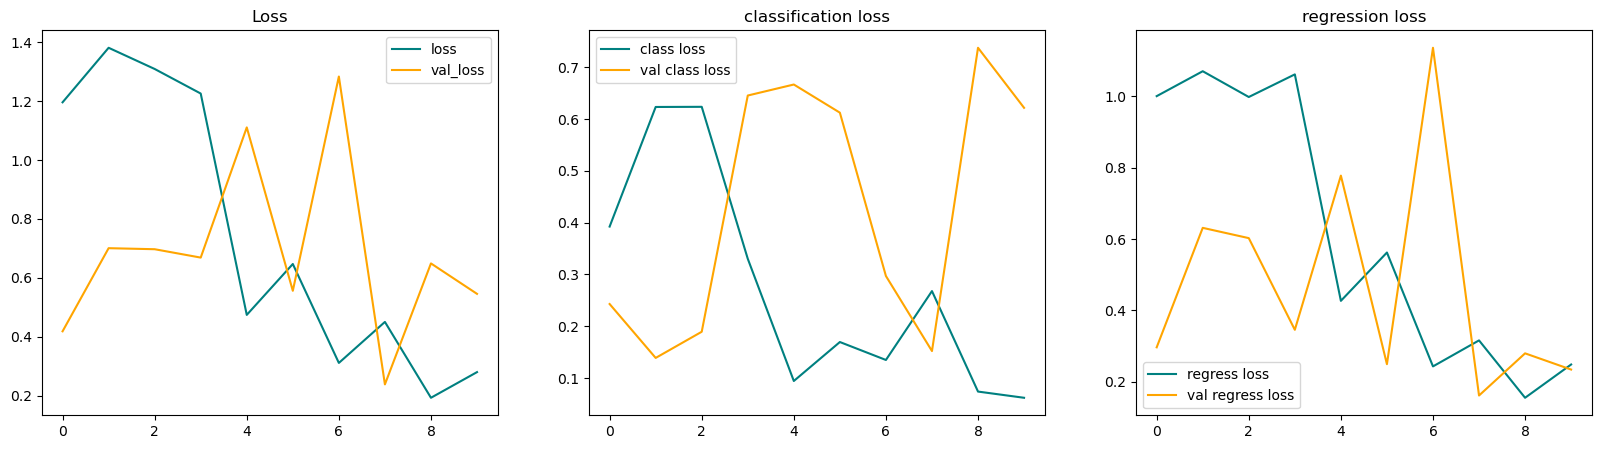

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize = (20,5))

ax[0].plot(history['total_loss'], color = 'teal', label = 'loss')
ax[0].plot(history["val_total_loss"], color = 'orange', label = 'val_loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history['class_loss'], color = 'teal', label = 'class loss')
ax[1].plot(history['val_class_loss'], color = 'orange', label = "val class loss")
ax[1].title.set_text("classification loss")
ax[1].legend()

ax[2].plot(history['regress_loss'], color = 'teal', label = 'regress loss')
ax[2].plot(history['val_regress_loss'], color = 'orange', label = "val regress loss")
ax[2].title.set_text("regression loss")
ax[2].legend()

plt.show()

# 11. Make Predictions

## 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 758ms/step


fig, ax = plt.subplots(ncols = 2, figsize = (10,10))
for idx in range(2):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.6:
        cv2.rectangle(sample_image,
                     tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                     tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                     (255,0,0),2)
        ax[idx].imshow(sample_image)

## 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[:, :, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    print(yhat[1])
    sample_coords = yhat[1][0]
    print(sample_coords[:2], sample_coords.shape)
    
    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [600,600]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [600,600]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [600,600]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [600,600]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [600,600]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()